# Clustering des bulletins de décennie 1960

### Imports

In [17]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [20]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load data et choisir une décennie

In [3]:
data_path = "../data/txt/"

In [4]:
DECADE = '1960'

### Charger tous les fichiers de la décennie et en créer une liste de textes

In [5]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [13]:
# Exemple de fichiers
files[40:50]

['Bxl_1964_Tome_II2_Part_4.txt',
 'Bxl_1964_Tome_I_Part_1.txt',
 'Bxl_1964_Tome_I_Part_5.txt',
 'Bxl_1965_Tome_II1_Part_1.txt',
 'Bxl_1965_Tome_II1_Part_2.txt',
 'Bxl_1965_Tome_II1_Part_8.txt',
 'Bxl_1965_Tome_II2_Part_13.txt',
 'Bxl_1965_Tome_II2_Part_14.txt',
 'Bxl_1965_Tome_II2_Part_4.txt',
 'Bxl_1965_Tome_II2_Part_7.txt']

In [14]:
texts = [open(data_path + f).read() for f in files]

# Exemple de textes
texts[0][:400]

"—\n\n101 —\n\n(12 septembre\n\n1960)\n\n17\nCommission d'Assistance\nActes divers\n\npublique.\n\nd'administration.\n\nM . l'Echevin Piron, au nom du Collège, soumet au Conseil les projets d'arrêtés suivants:\nHôpital Saint-Pierre.\nNouveau Service de Garde.\nPrincipe d'une dépense de 2.543.770 francs\npour la fourniture de matériel\nd'équipement.\nPar délibération en date du 3 mai 1960, la Commission\nd'Assistance publ"

### Vectoriser les documents à l'aide de TF-IDF

In [15]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens
# test

### Instancier le modèle TF-IDF avec ses arguments

In [21]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

## Construire la matrice de vecteurs à l'aide de la fonction fit_transform

In [22]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 51.5 s, sys: 0 ns, total: 51.5 s
Wall time: 51.7 s


In [23]:
# Détail de la matrice
tfidf_vectors

<112x6372 sparse matrix of type '<class 'numpy.float64'>'
	with 153954 stored elements in Compressed Sparse Row format>

## Imprimer le vecteur tf-IDF du premier document

In [24]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

# Result fills the matrix and ranks by most relevant words

+considérant    0.555594
compétent       0.232767
considérant     0.220013
appareil        0.208255
a+l'honneur     0.186103
                  ...   
enquêtes        0.000000
enquête         0.000000
enkele          0.000000
enkel           0.000000
™               0.000000
Length: 6372, dtype: float64

## Tests sur mes documents

In [25]:
tfidf_array = tfidf_vectors.toarray()

In [26]:
# Vecteur du document 0
tfidf_array[0]

array([0.       , 0.0062906, 0.       , ..., 0.0143345, 0.       ,
       0.       ])

In [27]:
# Vecteur du document 1
tfidf_array[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
cosine(tfidf_array[0], tfidf_array[20])

0.9574017125602418

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

### Définir un nombre de clusters

In [60]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [61]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction fit_predict

In [62]:
clusters = km_model.fit_predict(tfidf_vectors)

In [63]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [64]:
#pprint(dict(clustering))

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA

In [65]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [66]:
reduced_vectors[:10]

array([[-0.35175532, -0.47743106],
       [-0.34027656, -0.45022389],
       [-0.06664859, -0.14347122],
       [-0.2787561 , -0.34200575],
       [ 0.00074074, -0.1011187 ],
       [ 0.02348195, -0.11220646],
       [ 0.01084433, -0.11886865],
       [-0.25745778, -0.30173808],
       [-0.26503885, -0.34169949],
       [-0.02720647, -0.07987783]])

### Générer le plot

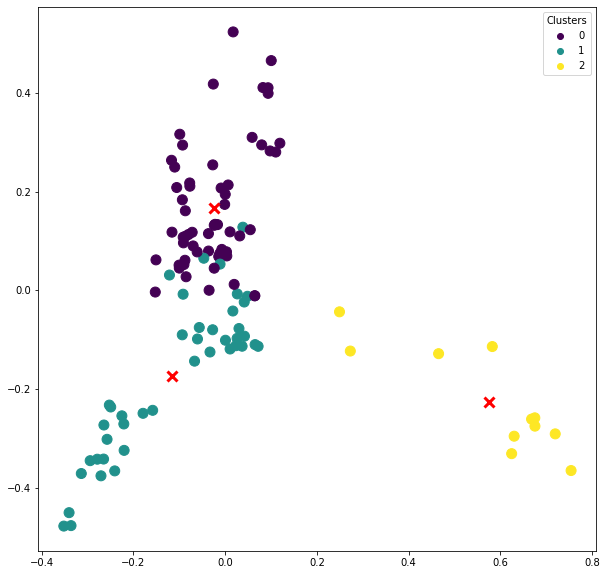

In [67]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 3, color='red')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

#### Clusters = 5

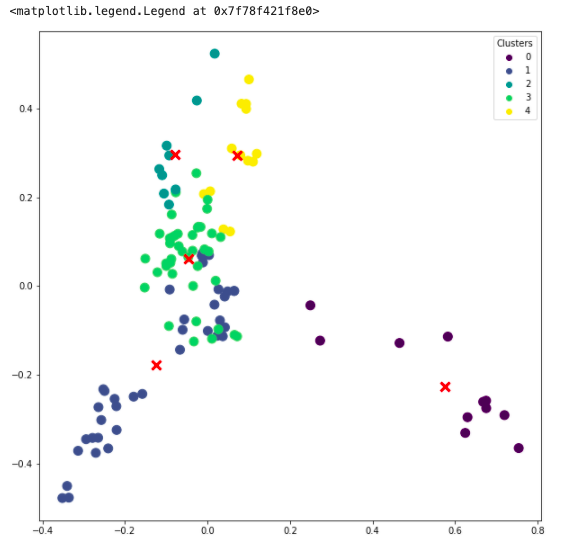

#### Clusters = 4 

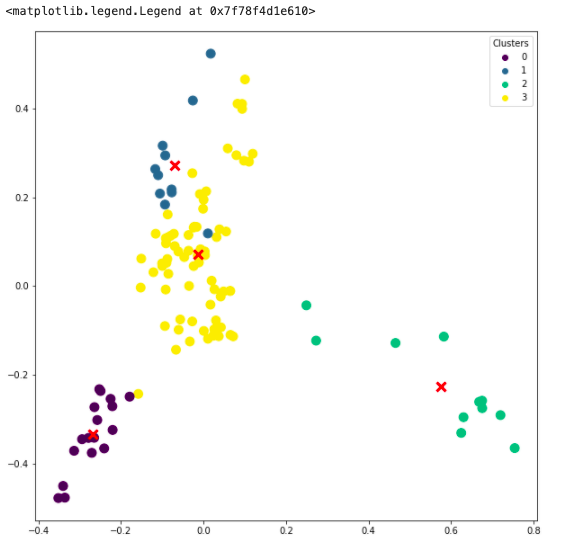